# DEC520 - SECTION A - TEAM 1 - Sentiment Analysis of Feedback Emails

Importing Necessary Packages and Aliasing

In [1]:
import numpy as np
import pandas as pd
import statistics
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_auc_score, f1_score, classification_report, accuracy_score, confusion_matrix, make_scorer, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold
from IPython.display import clear_output
from gensim import corpora
import pickle
import gensim
import statsmodels.api as sm
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from os import path
import os
import itertools
import collections
import itertools
import collections
import plotly
import plotly.express as px
from matplotlib import figure
import scipy.sparse as sp

In [2]:
stopwordsnltk = stopwords.words('english')
stopwordsnltk.remove('not')
stemmer = PorterStemmer()

# DATA CLEANING

Function to Load Data
    - Loads data from csv to dataframe

In [3]:
def load_data(file_path):
    df = pd.DataFrame()
    df = pd.read_csv(file_path)
    selected_cols=['stars','text']
    for colname in df.columns:
        if colname not in selected_cols:
           df = df.drop([colname],axis =1)
    return(df)

Text Processing Functions:
    - Converts to raw text
    - Removes stopwords
    - Lemmatizes words (conversion to root)

In [4]:
def process(str):
    str=str.lower()
    punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    
    for ele in str:
        if ele in punc:
            str = str.replace(ele, "")
    
    mysplit = str.split()
    droplist = []
    str1 =""
    for k in range(len(mysplit)):
        if mysplit[k] in stopwordsnltk:
            droplist.append(mysplit[k])
    for k in range(len(mysplit)):
        if mysplit[k] not in droplist:
            str1 = str1 + stemmer.stem(mysplit[k]) + " "
    
    return(str1)


    - Iteratively process reviews and assign sentiment label based on star rating

In [5]:
def proc_df(df):
    for i in range(len(df)):
        df.loc[i,'processed'] = process(df.loc[i,'text'])   
    for i in range(len(df)):
        if int(df.loc[i,'stars']) >= 3: 
            df.loc[i,'sentiment'] = 1
        else:
            df.loc[i,'sentiment'] = -1
    return(df)

# Feature Engineering

### Bag Of Words

Function to Create Table of Words with Positive and Negative Count

In [6]:
def gen_freq_mat(df1):
    freq_mat = pd.DataFrame(columns = ['words','positive','negative'])
    for i in range(len(df1)):
        s = df1.loc[i,'processed'].split()
        sent = df1.loc[i,'sentiment']
        for j in range(len(s)):
            if s[j] in list(freq_mat.words):
                if sent == 1:
                    freq_mat.loc[freq_mat.index[freq_mat.words==s[j]],'positive'] += 1
                else:
                    freq_mat.loc[freq_mat.index[freq_mat.words==s[j]],'negative'] += 1
            else:
                freq_mat.loc[len(freq_mat),'words']=s[j]
                if sent == 1:
                    freq_mat.loc[len(freq_mat)-1,'positive'] = 1
                    freq_mat.loc[len(freq_mat)-1, 'negative'] = 0
                else:
                    freq_mat.loc[len(freq_mat)-1,'positive'] = 0
                    freq_mat.loc[len(freq_mat)-1, 'negative'] = 1
        if i%(len(df1)/100) ==0:
            clear_output(wait=True)
            print('Generating Frequency Matrix:',i/(len(df1)/100), '% done')
    clear_output(wait=True)
    print('Frequency Matrix Generated Successfully.')
    return(freq_mat)


    - Process frequency table into vocabulary and categorize words as positive or negative

In [7]:
def gen_vocab(freq_mat,count_thresh, power_thres_pos, power_thres_neg):
    freq_mat.loc[:,'total_count'] = freq_mat.loc[:,'positive'] +  freq_mat.loc[:,'negative']
    freq_mat.loc[:,'sentiment_power'] = abs(freq_mat.loc[:,'positive'] -  freq_mat.loc[:,'negative'])/freq_mat.loc[:,'total_count']
    freq_mat.loc[:,'sentiment_score'] = freq_mat.loc[:,'positive'] -  freq_mat.loc[:,'negative']
    freq_mat = freq_mat.sort_values('sentiment_score', ascending = 0)
    freq_mat = freq_mat.reset_index(drop=1)
    vocab = freq_mat[(freq_mat.total_count > count_thresh)&(freq_mat.sentiment_score!=0)]
    vocab.loc[:,'label'] = vocab.sentiment_score/abs(vocab.sentiment_score)
    vocab = vocab[(vocab.sentiment_power*vocab.label>power_thres_pos)|(vocab.sentiment_power*vocab.label<power_thres_neg)]
    clear_output(wait=True)
    print('Vocabulary Generated Successfully.')
    return(vocab)

Macro to Process DataFrame and convert it to a vocabulary by running the above functions.

In [8]:
def generate_vocab(df_train, count_thresh, power_thres_pos, power_thres_neg):
    df_train = proc_df(df_train)
    print('Text processed')
    freq_mat_train = gen_freq_mat(df_train)
    vocab = gen_vocab(freq_mat_train,count_thresh,power_thres_pos, power_thres_neg)
    print('Vocabulary of ',len(vocab),' words created')
    return vocab;

Fuctions to Initialize and Populate Bag of Words

In [9]:
def create_bag(vocab):
    bag = pd.DataFrame(columns = vocab.words)
    return bag;

Note that we have created a contextual flag for NOT and ISNT. This allows us to include some contextual predictions, since bigrams did not yeild desired results.

In [10]:
def add_element_to_bag(str,bag):
    s = str.split()
    bag.loc[len(bag)] = np.zeros(len(bag.columns)) 
    invert_flag = 1
    for j in range(len(s)):
        if s[j] in list(bag.columns):
            bag.loc[len(bag)-1,s[j]] += invert_flag
        if (s[j] == 'not') | (s[j] == 'isnt'):
            invert_flag *= -1
        else:
            invert_flag = 1

In [11]:
def populate_bag(df,vocab):
    bag = pd.DataFrame(columns = vocab.words)
    outcomes = pd.DataFrame(columns = ['Sentiment'])
    outcomes.loc[:,'Sentiment'] = (df.sentiment + 1)/2
    for i in range(len(df.index)):
        str = df.loc[i,'processed']
        add_element_to_bag(str,bag)
        if i%(len(df.index)/100) ==0:
            clear_output(wait=True)
            print('Bag of Words Generation',i/(len(df.index)/100), '% done') 
    bag1 = pd.concat([bag,outcomes], axis = 1)
    clear_output(wait=True)
    print('Bag of Words Populated Successfully.')
    return(bag1);

Initializing a dataframe to hold actual sentiment, predicted sentiment, and probability outputs from the model.

In [12]:
def test_log_frame(test_df,logreg):
    y = list(test_df['Sentiment'])
    x = test_df.drop('Sentiment',axis = 1)
    df_preds = pd.DataFrame(logreg.predict_proba(x), columns =['0','prob'])
    df_preds = df_preds.drop('0',axis = 1)
    df_preds['pred'] = np.zeros(len(df_preds))
    df_preds['act'] = y
    return(df_preds)

The below two functions are just made to check how the model is performing using a single string input. These are not essential to our project

In [13]:
def populate_bag_single(str,vocab):
    bag = pd.DataFrame(columns = vocab.words)
    add_element_to_bag_not_considered(str,bag)
    return(bag);

In [14]:
def predict_from_string(string,vocab,model):
    string = process(string)
    bag = create_bag(vocab)
    X = populate_bag_single(string, vocab)
    return model.predict_proba(X);

Funciton to create contingency table

### Topic Modelling

 Function creates a list of bigrams for each review using the processed text

In [15]:
###function creates a list of bigrams for each review using the processed text
def bag_of_bigram(df_proc):
    bigram_df = []
    for i in np.arange(0,len(df_proc['text'])): 
        text = df_proc["processed"][i]
        text_split = text.split(" ")
        text_list=[]
        for j in np.arange(0,len(text_split)-1):
            text_list.append(text_split[j]+"_"+text_split[j+1])
        bigram_df.append(text_list)
    df_proc["bigram"]=bigram_df
    return df_proc

 Function creates a resample the good and bad reviews so that we get a balance number of reviews with positive and negative sentiment

In [16]:
def resample_df(df_proc):
    bad_reviews = df_proc[df_proc["stars"]<=3].reset_index().drop(columns=["index"])
    good_reviews = df_proc[df_proc["stars"]>3].reset_index().drop(columns=["index"])
    df_resampled = pd.concat([bad_reviews,good_reviews[0:13000]],ignore_index = True) #incorporate more negative reviews because 50-50 will skew towards positive topics
    return df_resampled

Takes in a dataframe with reviews broken down into bigrams and return list of topics

In [17]:
def generate_topic(df_bigram):
    dictionary = corpora.Dictionary(df_bigram["bigram"])
    corpus = [dictionary.doc2bow(text) for text in df_bigram["bigram"]]
    pickle.dump(corpus, open('corpus.pkl', 'wb'))
    dictionary.save('dictionary.gensim')
    NUM_TOPICS = 20
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=1)
    ldamodel.save('model20.gensim')
    topics = ldamodel.print_topics(num_words=30) #adds each word into the topcis
    for topic in topics:
        print(topic)
    document_topics = [ldamodel.get_document_topics(item,minimum_probability=0) for item in corpus]
    return document_topics

In [18]:
def generate_topic_df(document_topics):
    model_dict={
    "topic1":[],
    "topic2":[],
    "topic3":[],
    "topic4":[],
    "topic5":[],
    "topic6":[],
    "topic7":[],
    "topic8":[],
    "topic9":[],
    "topic10":[],
    "topic11":[],
    "topic12":[],
    "topic13":[],
    "topic14":[],
    "topic15":[],
    "topic16":[],
    "topic17":[],
    "topic18":[],
    "topic19":[],
    "topic20":[]
    }
    for i in np.arange(0,len(document_topics)):
        for j in np.arange(0,20):
            model_dict["topic"+str(j+1)].append(document_topics[i][j][1]) #append the score of each review to dictionary
    df_topic=pd.DataFrame(model_dict)
    return df_topic

In [19]:
def combine_topics_sentiment (df_topic,resample_df):
    df_topic["stars"]= resample_df["stars"]
    sentiment =[]
    for i in np.arange(0,len(df_topic)):
        if(df_topic["stars"][i]>=3):
            sentiment.append(1)
        else:
            sentiment.append(-1)
    df_topic["sentiment"]=sentiment
    return df_topic  

In [20]:
def running_regression (topic_df):
    X = topic_df.iloc[:,0:19]
    Y = topic_df["stars"]
    X = sm.add_constant(X)
    mod = sm.OLS(Y,X)
    res = mod.fit()
    print(res.summary())
    Y = topic_df["sentiment"]
    mod = sm.OLS(Y,X)
    res = mod.fit()
    print(res.summary())

In [21]:
def running_models (topic_df):
    LR = LogisticRegression()
    RF = RandomForestClassifier()
    GB = GradientBoostingClassifier()
    SV = SVC()
    x = topic_df.drop(columns=["stars","sentiment"])
    y = topic_df["sentiment"]
    scoring = {'accuracy' : make_scorer(accuracy_score),
           'f1_score' : make_scorer(f1_score),
           'AUC' : make_scorer(roc_auc_score)}
    print('Logistic AUC: ', statistics.mean(cross_validate(LR, x, y, cv=10, scoring = scoring)['test_AUC']))
    print('Random Forest AUC: ', statistics.mean(cross_validate(RF, x, y, cv=10, scoring = scoring)['test_AUC']))
    print('Gradient Boosting AUC: ', statistics.mean(cross_validate(GB, x, y, cv=10, scoring = scoring)['test_AUC']))
    print('Support Vector AUC: ', statistics.mean(cross_validate(SV, x, y, cv=10, scoring = scoring)['test_AUC']))

# Evaluation

Function to generate contingency table

In [22]:
def contingency_stats (dfp,x):
    for i in range(len(dfp)):
        if dfp.prob[i]>x:
            dfp.loc[i,'pred'] = 1
        else:
            dfp.loc[i,'pred'] = 0
    contingency = pd.DataFrame(np.zeros([2,2]))
    for i in range(len(dfp)):
        if dfp.act[i] == 0 and dfp.pred[i] == 0:
            contingency.loc[0,0] +=1
        elif dfp.act[i] == 1 and dfp.pred[i] == 0:
            contingency.loc[1,0] +=1
        elif dfp.act[i] == 0 and dfp.pred[i] == 1:
            contingency.loc[0,1] +=1
        elif dfp.act[i] == 1 and dfp.pred[i] == 1:
            contingency.loc[1,1] +=1
    
    TPR = contingency.loc[1,1]/sum(contingency.loc[1,:])
    FPR = contingency.loc[0,1]/sum(contingency.loc[0,:])
    contingency.columns = ['Pred. Neg','Pred. Pos']
    contingency.index = ['Act. Neg', 'Act. Pos']
    print('Contingency Table: \n',contingency)        
    print('TPR is equal to : ', TPR)
    print('FPR is equal to : ', FPR)

Function to Compute TPR and FPR

In [23]:
def TPR_FPR (dfp,x):
    for i in range(len(dfp)):
        if dfp.prob[i]>x:
            dfp.loc[i,'pred'] = 1
        else:
            dfp.loc[i,'pred'] = 0
    contingency = pd.DataFrame(np.zeros([2,2]))
    for i in range(len(dfp)):
        if dfp.act[i] == 0 and dfp.pred[i] == 0:
            contingency.loc[0,0] +=1
        elif dfp.act[i] == 1 and dfp.pred[i] == 0:
            contingency.loc[1,0] +=1
        elif dfp.act[i] == 0 and dfp.pred[i] == 1:
            contingency.loc[0,1] +=1
        elif dfp.act[i] == 1 and dfp.pred[i] == 1:
            contingency.loc[1,1] +=1
            
    TPR = contingency.loc[1,1]/sum(contingency.loc[1,:])
    FPR = contingency.loc[0,1]/sum(contingency.loc[0,:])
    return([TPR,FPR,x])

Function to calculate coordinates for ROC curve

In [24]:
def ROC_curve(df_preds):
    df_ROC = pd.DataFrame(columns=['TPR','FPR','Thres'])
    thresh = np.arange(0.05,0.96,0.01)
    for i in range(len(thresh)):
        df_ROC.loc[i,:] = TPR_FPR(df_preds,thresh[i])
    return(df_ROC)

Computation of Overall Accuracy

In [25]:
def accuracy(dfp,th):
    for i in range(len(dfp)):
        if dfp.prob[i]>th:
            dfp.loc[i,'pred'] = 1
        else:
            dfp.loc[i,'pred'] = 0
    contingency = pd.DataFrame(np.zeros([2,2]))
    for i in range(len(dfp)):
        if dfp.act[i] == 0 and dfp.pred[i] == 0:
            contingency.loc[0,0] +=1
        elif dfp.act[i] == 1 and dfp.pred[i] == 0:
            contingency.loc[1,0] +=1
        elif dfp.act[i] == 0 and dfp.pred[i] == 1:
            contingency.loc[0,1] +=1
        elif dfp.act[i] == 1 and dfp.pred[i] == 1:
            contingency.loc[1,1] +=1
    acc = (contingency.loc[0,0]+contingency.loc[1,1])/(contingency.loc[0,0]+contingency.loc[0,1]+contingency.loc[1,0]+contingency.loc[1,1])
    return(acc)

Measuring Accuracy at different thresholds

In [26]:
def accuracy_plot(df_preds1):
    acc_plot_df = pd.DataFrame(columns=['Perc_thres','Accuracy'])
    for x in range(100):
        acc_plot_df.loc[x,'Perc_thres'] = x+1
        acc_plot_df.loc[x,'Accuracy'] = accuracy(df_preds1,(x+1)/100)
    return (acc_plot_df)

Macro to output relevant Test Statistics

In [27]:
def test_statistics (preds_frame_test, thres):
    print('Test stats are as follows: ')
    contingency_stats(preds_frame_test, thres)
    print('Accuracy for test set is ', accuracy(preds_frame_test, thres)*100,'% at threshold = ', thres)
#     acc_test = accuracy_plot(preds_frame_test)
#     max_test_thres = int(acc_test.loc[acc_test.index[acc_test.Accuracy==max(acc_test.Accuracy)][0],'Perc_thres'])/100
#     print('Max Accuracy of ',max(acc_test.Accuracy)*100,'% at a threshold of ',max_test_thres)
    

Cost Function for Estimating Performance in Business Case

In [28]:
def cost_benefit(test_frame,tn,fp,fn,tp,thr):
    test_frame['pred'] = test_frame['prob'].apply(lambda x: 1 if x>thr else 0)
    cm = confusion_matrix(test_frame.act, test_frame.pred)
    exp_prof = cm[0][0]*tn + cm[0][1]*fp + cm[1][0]*fn + cm[1][1]*tp
    return exp_prof;

# EXECUTION

## Exploratory Data Analysis and Visualizations

In [29]:
df_train = load_data("BalRev.csv")

In [30]:
df_sampled= resample_df(df_train)
df_proc = proc_df(df_sampled)

In [31]:
#Splitting words
words_in_review = [review.lower().split() for review in df_proc.processed]
words_in_review[:2]

# List of all words across tweets

all_words_no_urls = list(itertools.chain(*words_in_review))

# Create counter
counts_no_urls = collections.Counter(all_words_no_urls)

counts_no_urls.most_common(50)

[('not', 1574),
 ('place', 1145),
 ('food', 1113),
 ('good', 972),
 ('time', 890),
 ('like', 848),
 ('get', 846),
 ('go', 839),
 ('servic', 788),
 ('great', 744),
 ('one', 729),
 ('order', 706),
 ('back', 666),
 ('would', 654),
 ('even', 546),
 ('realli', 496),
 ('us', 494),
 ('tri', 493),
 ('wait', 482),
 ('come', 477),
 ('got', 453),
 ('dont', 426),
 ('want', 424),
 ('look', 421),
 ('also', 398),
 ('love', 393),
 ('ask', 391),
 ('restaur', 385),
 ('never', 379),
 ('first', 376),
 ('day', 372),
 ('im', 371),
 ('came', 364),
 ('make', 355),
 ('well', 352),
 ('didnt', 348),
 ('nice', 339),
 ('peopl', 335),
 ('could', 333),
 ('ive', 326),
 ('price', 321),
 ('chicken', 318),
 ('call', 316),
 ('drink', 314),
 ('went', 313),
 ('take', 312),
 ('said', 301),
 ('much', 301),
 ('staff', 300),
 ('best', 299)]

In [32]:
df_proc.head()

stars                                               text  \
0      2  Drinks were great as was the bartender.  Then ...   
1      1  I would give this zero stars if that was an op...   
2      1  Filthy n terrible customer service. I stood th...   
3      1  Rating: 0.5/5 \r\n\r\nI had high hopes for thi...   
4      2  Waited over 30 minutes for my free birthday pi...   

                                           processed  sentiment  
0  drink great bartend bar food return calamari b...       -1.0  
1  would give zero star option aw custom servic o...       -1.0  
2  filthi n terribl custom servic stood almost 10...       -1.0  
3  rate 055 high hope place especi see zagat rate...       -1.0  
4  wait 30 minut free birthday pizza juli 29th 20...       -1.0

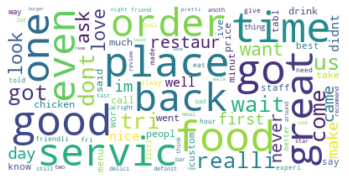

<Figure size 432x288 with 0 Axes>

In [33]:
#Word cloud for most common words
#Properly tabulating
clean_review_no_urls = pd.DataFrame(counts_no_urls.most_common(100),
                             columns=['words', 'count'])

clean_review_no_urls

# Start with one review:
text = " ".join(review for review in clean_review_no_urls.words)

# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

plt.savefig('wordcloud1.png')

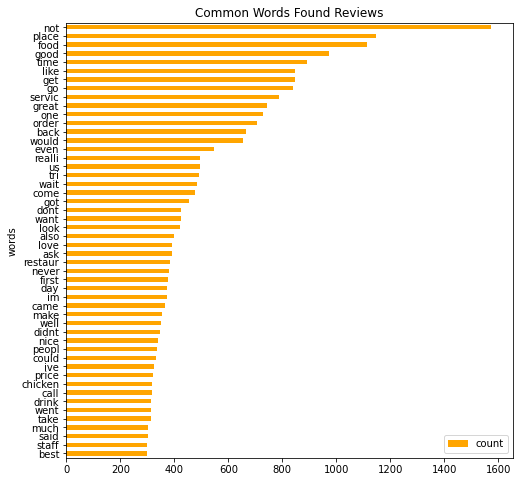

In [34]:
#Properly tabulating
clean_review_no_urls = pd.DataFrame(counts_no_urls.most_common(50),
                             columns=['words', 'count'])

clean_review_no_urls


#Plotting most common words
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
clean_review_no_urls.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="orange")

ax.set_title("Common Words Found Reviews")

plt.show()

In [35]:
#Required code

df_train = df_train

df_sampled= resample_df(df_train)
df_proc = proc_df(df_sampled)

df_bigram = bag_of_bigram(df_proc)
df_bigram

#Pre processing for bigrams
#Splitting words
review =[]
words_in_review = [review for review in df_bigram.bigram]
words_in_review[:2]

# List of all words across tweets

all_words_no_urls = list(itertools.chain(*words_in_review))

# Create counter
counts_no_urls = collections.Counter(all_words_no_urls)

counts_no_urls.most_common(50)

#Properly tabulating
clean_review_no_urls = pd.DataFrame(counts_no_urls.most_common(20),
                             columns=['words', 'count'])

clean_review_no_urls


words  count
0            go_back    140
1      custom_servic    114
2          come_back    113
3              back_     87
4             im_not     79
5         first_time     78
6        realli_good     62
7          look_like     57
8          food_good     57
9          would_not     53
10        happi_hour     52
11  highli_recommend     52
12         dont_know     51
13         tast_like     51
14         good_food     48
15          not_even     47
16         feel_like     47
17          not_good     45
18       even_though     45
19         seem_like     45

In [36]:
#Visualizing bi-grams
fig = px.scatter(clean_review_no_urls, x='words',y='count', hover_name='words', text='words', size='count', color='words', size_max=45
                 , template='plotly_white', title='Bigram similarity and frequency', labels={'words': 'Words'}
                 , color_continuous_scale=px.colors.sequential.Sunsetdark)
fig.update_traces(marker=dict(line=dict(width=1, color='Gray')))
fig.update_xaxes(visible=True)
fig.update_yaxes(visible=True)
fig.show()

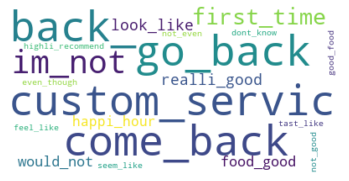

In [37]:
#Adding word clouds for bigrams
# Start with one review:
text = " ".join(review for review in clean_review_no_urls.words)

# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [38]:
#Required code
dictionary = corpora.Dictionary(df_bigram["bigram"])
corpus = [dictionary.doc2bow(text) for text in df_bigram["bigram"]]
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')
NUM_TOPICS = 20
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=1)
ldamodel.save('model20.gensim')
topics = ldamodel.print_topics(num_words=30) #adds each word into the topcis
used_word={}
for topic in topics:
    print(topic)
    
#Creating a dataframe from topics
df_topics_one=pd.DataFrame(topics)
df_topics_one.columns = ['Topic', 'Words_with_weights']
df_topics_one


(0, '0.001*"go_back" + 0.001*"love_place" + 0.001*"custom_servic" + 0.000*"im_not" + 0.000*"come_back" + 0.000*"back_" + 0.000*"highli_recommend" + 0.000*"staff_friendli" + 0.000*"look_forward" + 0.000*"time_order" + 0.000*"3_time" + 0.000*"one_best" + 0.000*"look_like" + 0.000*"recommend_" + 0.000*"help_us" + 0.000*"servic_great" + 0.000*"menu_" + 0.000*"tast_like" + 0.000*"servic_" + 0.000*"would_not" + 0.000*"first_time" + 0.000*"dont_think" + 0.000*"10_minut" + 0.000*"sweet_potato" + 0.000*"fish_chip" + 0.000*"meatbal_sub" + 0.000*"front_desk" + 0.000*"dine_room" + 0.000*"not_good" + 0.000*"realli_good"')
(1, '0.001*"custom_servic" + 0.001*"dont_know" + 0.000*"come_back" + 0.000*"im_not" + 0.000*"look_like" + 0.000*"would_not" + 0.000*"next_time" + 0.000*"2_hour" + 0.000*"good_food" + 0.000*"go_back" + 0.000*"could_not" + 0.000*"like_place" + 0.000*"not_good" + 0.000*"10_minut" + 0.000*"walk_around" + 0.000*"first_time" + 0.000*"realli_like" + 0.000*"dont_think" + 0.000*"half_hour"

Topic                                 Words_with_weights
0       0  0.001*"go_back" + 0.001*"love_place" + 0.001*"...
1       1  0.001*"custom_servic" + 0.001*"dont_know" + 0....
2       2  0.002*"go_back" + 0.001*"back_" + 0.001*"come_...
3       3  0.001*"credit_card" + 0.000*"go_back" + 0.000*...
4       4  0.001*"custom_servic" + 0.001*"go_back" + 0.00...
5       5  0.001*"first_time" + 0.000*"custom_servic" + 0...
6       6  0.001*"come_back" + 0.001*"go_back" + 0.001*"g...
7       7  0.001*"back_" + 0.001*"come_back" + 0.001*"go_...
8       8  0.001*"custom_servic" + 0.001*"first_time" + 0...
9       9  0.001*"realli_good" + 0.001*"go_back" + 0.001*...
10     10  0.001*"custom_servic" + 0.001*"come_back" + 0....
11     11  0.001*"come_back" + 0.001*"back_" + 0.001*"foo...
12     12  0.001*"custom_servic" + 0.001*"come_back" + 0....
13     13  0.001*"go_back" + 0.001*"im_not" + 0.000*"cust...
14     14  0.001*"come_back" + 0.001*"go_back" + 0.001*"b...
15     15  0.001*"go_back" + 0.000*"custom_servic" + 0.00...
16     16  0.001*"come_back" + 0.001*"go_back" + 0.001*"l...
17     17  0.001*"go_back" + 0.001*"back_" + 0.001*"seem_...
18     18  0.001*"go_back" + 0.001*"custom_servic" + 0.00...
19     19  0.001*"go_back" + 0.001*"come_back" + 0.000*"m...

In [39]:
new_df = pd.DataFrame(df_topics_one.Words_with_weights.str.split('+').tolist(), index=df_topics_one.Topic).stack()
new_df = new_df.reset_index([0, 'Topic'])
new_df.columns = ['Topic', 'Words_with_weights']
new_df[['Weight','Word']] = new_df.Words_with_weights.str.split("*",expand=True)
new_df


Topic       Words_with_weights  Weight              Word
0        0         0.001*"go_back"    0.001        "go_back" 
1        0      0.001*"love_place"    0.001     "love_place" 
2        0   0.001*"custom_servic"    0.001  "custom_servic" 
3        0          0.000*"im_not"    0.000         "im_not" 
4        0       0.000*"come_back"    0.000      "come_back" 
..     ...                      ...     ...               ...
595     19       0.000*"feel_like"    0.000      "feel_like" 
596     19         0.000*"want_go"    0.000        "want_go" 
597     19       0.000*"good_food"    0.000      "good_food" 
598     19      0.000*"time_visit"    0.000     "time_visit" 
599     19          0.000*"not_one"   0.000         "not_one"

[600 rows x 4 columns]

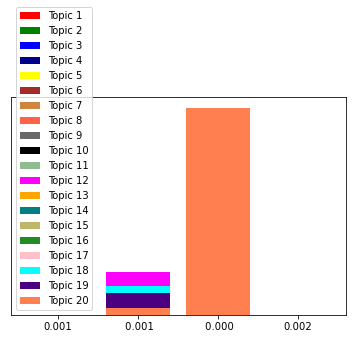

In [40]:
import numpy as np
import matplotlib.pyplot as plt


mask1 = new_df.Topic == 0
mask2 = new_df.Topic == 1
mask3 = new_df.Topic == 2
mask4 = new_df.Topic == 3
mask5 = new_df.Topic == 4
mask6 = new_df.Topic == 5
mask7 = new_df.Topic == 6
mask8 = new_df.Topic == 7
mask9 = new_df.Topic == 8
mask10 = new_df.Topic == 9
mask11 = new_df.Topic == 10
mask12 = new_df.Topic == 11
mask13 = new_df.Topic == 12
mask14 = new_df.Topic == 13
mask15 = new_df.Topic == 14
mask16 = new_df.Topic == 15
mask17 = new_df.Topic == 16
mask18 = new_df.Topic == 17
mask19 = new_df.Topic == 18
mask20 = new_df.Topic == 19


plt.bar(new_df.Weight[mask1], new_df.Word[mask1], color = 'red')
plt.bar(new_df.Weight[mask2], new_df.Word[mask1], color = 'green')
plt.bar(new_df.Weight[mask3], new_df.Word[mask1], color = 'blue')
plt.bar(new_df.Weight[mask4], new_df.Word[mask1], color = 'darkblue')
plt.bar(new_df.Weight[mask5], new_df.Word[mask1], color = 'yellow')
plt.bar(new_df.Weight[mask6], new_df.Word[mask1], color = 'brown')
plt.bar(new_df.Weight[mask7], new_df.Word[mask1], color = 'peru')
plt.bar(new_df.Weight[mask8], new_df.Word[mask1], color = 'tomato')
plt.bar(new_df.Weight[mask9], new_df.Word[mask1], color = 'dimgray')
plt.bar(new_df.Weight[mask10], new_df.Word[mask1], color = 'black')
plt.bar(new_df.Weight[mask11], new_df.Word[mask1], color = 'darkseagreen')
plt.bar(new_df.Weight[mask12], new_df.Word[mask1], color = 'magenta')
plt.bar(new_df.Weight[mask13], new_df.Word[mask1], color = 'orange')
plt.bar(new_df.Weight[mask14], new_df.Word[mask1], color = 'teal')
plt.bar(new_df.Weight[mask15], new_df.Word[mask1], color = 'darkkhaki')
plt.bar(new_df.Weight[mask16], new_df.Word[mask1], color = 'forestgreen')
plt.bar(new_df.Weight[mask17], new_df.Word[mask1], color = 'pink')
plt.bar(new_df.Weight[mask18], new_df.Word[mask1], color = 'aqua')
plt.bar(new_df.Weight[mask19], new_df.Word[mask1], color = 'indigo')
plt.bar(new_df.Weight[mask20], new_df.Word[mask1], color = 'coral')
#plt.bar(x[mask2], y[mask2], color = 'blue')
ax = plt.gca()
ax.axes.xaxis.set_visible(True)
ax.axes.yaxis.set_visible(False)
plt.legend(['Topic 1', 'Topic 2','Topic 3','Topic 4','Topic 5','Topic 6','Topic 7','Topic 8','Topic 9','Topic 10','Topic 11','Topic 12','Topic 13','Topic 14','Topic 15','Topic 16','Topic 17','Topic 18','Topic 19','Topic 20'])
# plt.rcParams["figure.figsize"] = (50,3)
plt.show()

0    False
1    False
2    False
3    False
4    False
Name: Topic, dtype: bool
    Topic          Words_with_weights  Weight                 Word
60      2            0.002*"go_back"    0.002           "go_back" 
61      2              0.001*"back_"    0.001             "back_" 
62      2          0.001*"come_back"    0.001         "come_back" 
63      2             0.001*"not_go"    0.001            "not_go" 
64      2          0.001*"wast_time"    0.001         "wast_time" 
65      2         0.000*"first_time"    0.000        "first_time" 
66      2         0.000*"great_food"    0.000        "great_food" 
67      2          0.000*"dine_room"    0.000         "dine_room" 
68      2           0.000*"food_not"    0.000          "food_not" 
69      2        0.000*"realli_good"    0.000       "realli_good" 
70      2          0.000*"ice_cream"    0.000         "ice_cream" 
71      2          0.000*"feel_like"    0.000         "feel_like" 
72      2           0.000*"not_even"    0.000    

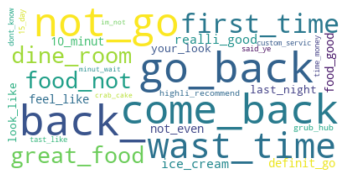

0    False
1    False
2    False
3    False
4    False
Name: Topic, dtype: bool
    Topic          Words_with_weights  Weight                 Word
60      2            0.002*"go_back"    0.002           "go_back" 
61      2              0.001*"back_"    0.001             "back_" 
62      2          0.001*"come_back"    0.001         "come_back" 
63      2             0.001*"not_go"    0.001            "not_go" 
64      2          0.001*"wast_time"    0.001         "wast_time" 
65      2         0.000*"first_time"    0.000        "first_time" 
66      2         0.000*"great_food"    0.000        "great_food" 
67      2          0.000*"dine_room"    0.000         "dine_room" 
68      2           0.000*"food_not"    0.000          "food_not" 
69      2        0.000*"realli_good"    0.000       "realli_good" 
70      2          0.000*"ice_cream"    0.000         "ice_cream" 
71      2          0.000*"feel_like"    0.000         "feel_like" 
72      2           0.000*"not_even"    0.000    

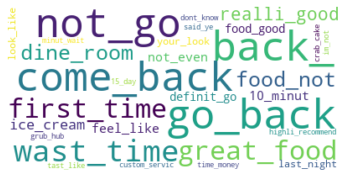

0    False
1    False
2    False
3    False
4    False
Name: Topic, dtype: bool
    Topic          Words_with_weights  Weight                 Word
60      2            0.002*"go_back"    0.002           "go_back" 
61      2              0.001*"back_"    0.001             "back_" 
62      2          0.001*"come_back"    0.001         "come_back" 
63      2             0.001*"not_go"    0.001            "not_go" 
64      2          0.001*"wast_time"    0.001         "wast_time" 
65      2         0.000*"first_time"    0.000        "first_time" 
66      2         0.000*"great_food"    0.000        "great_food" 
67      2          0.000*"dine_room"    0.000         "dine_room" 
68      2           0.000*"food_not"    0.000          "food_not" 
69      2        0.000*"realli_good"    0.000       "realli_good" 
70      2          0.000*"ice_cream"    0.000         "ice_cream" 
71      2          0.000*"feel_like"    0.000         "feel_like" 
72      2           0.000*"not_even"    0.000    

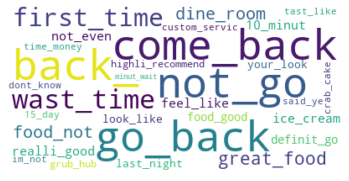

0    False
1    False
2    False
3    False
4    False
Name: Topic, dtype: bool
    Topic          Words_with_weights  Weight                 Word
60      2            0.002*"go_back"    0.002           "go_back" 
61      2              0.001*"back_"    0.001             "back_" 
62      2          0.001*"come_back"    0.001         "come_back" 
63      2             0.001*"not_go"    0.001            "not_go" 
64      2          0.001*"wast_time"    0.001         "wast_time" 
65      2         0.000*"first_time"    0.000        "first_time" 
66      2         0.000*"great_food"    0.000        "great_food" 
67      2          0.000*"dine_room"    0.000         "dine_room" 
68      2           0.000*"food_not"    0.000          "food_not" 
69      2        0.000*"realli_good"    0.000       "realli_good" 
70      2          0.000*"ice_cream"    0.000         "ice_cream" 
71      2          0.000*"feel_like"    0.000         "feel_like" 
72      2           0.000*"not_even"    0.000    

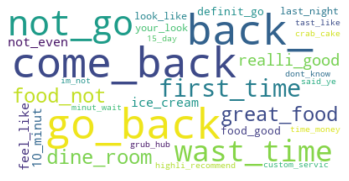

0    False
1    False
2    False
3    False
4    False
Name: Topic, dtype: bool
    Topic          Words_with_weights  Weight                 Word
60      2            0.002*"go_back"    0.002           "go_back" 
61      2              0.001*"back_"    0.001             "back_" 
62      2          0.001*"come_back"    0.001         "come_back" 
63      2             0.001*"not_go"    0.001            "not_go" 
64      2          0.001*"wast_time"    0.001         "wast_time" 
65      2         0.000*"first_time"    0.000        "first_time" 
66      2         0.000*"great_food"    0.000        "great_food" 
67      2          0.000*"dine_room"    0.000         "dine_room" 
68      2           0.000*"food_not"    0.000          "food_not" 
69      2        0.000*"realli_good"    0.000       "realli_good" 
70      2          0.000*"ice_cream"    0.000         "ice_cream" 
71      2          0.000*"feel_like"    0.000         "feel_like" 
72      2           0.000*"not_even"    0.000    

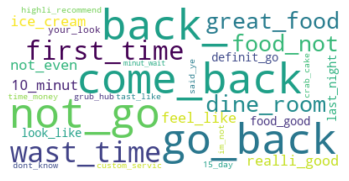

0    False
1    False
2    False
3    False
4    False
Name: Topic, dtype: bool
    Topic          Words_with_weights  Weight                 Word
60      2            0.002*"go_back"    0.002           "go_back" 
61      2              0.001*"back_"    0.001             "back_" 
62      2          0.001*"come_back"    0.001         "come_back" 
63      2             0.001*"not_go"    0.001            "not_go" 
64      2          0.001*"wast_time"    0.001         "wast_time" 
65      2         0.000*"first_time"    0.000        "first_time" 
66      2         0.000*"great_food"    0.000        "great_food" 
67      2          0.000*"dine_room"    0.000         "dine_room" 
68      2           0.000*"food_not"    0.000          "food_not" 
69      2        0.000*"realli_good"    0.000       "realli_good" 
70      2          0.000*"ice_cream"    0.000         "ice_cream" 
71      2          0.000*"feel_like"    0.000         "feel_like" 
72      2           0.000*"not_even"    0.000    

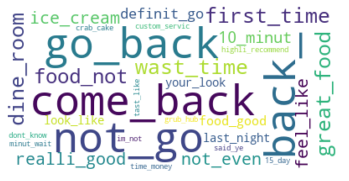

0    False
1    False
2    False
3    False
4    False
Name: Topic, dtype: bool
    Topic          Words_with_weights  Weight                 Word
60      2            0.002*"go_back"    0.002           "go_back" 
61      2              0.001*"back_"    0.001             "back_" 
62      2          0.001*"come_back"    0.001         "come_back" 
63      2             0.001*"not_go"    0.001            "not_go" 
64      2          0.001*"wast_time"    0.001         "wast_time" 
65      2         0.000*"first_time"    0.000        "first_time" 
66      2         0.000*"great_food"    0.000        "great_food" 
67      2          0.000*"dine_room"    0.000         "dine_room" 
68      2           0.000*"food_not"    0.000          "food_not" 
69      2        0.000*"realli_good"    0.000       "realli_good" 
70      2          0.000*"ice_cream"    0.000         "ice_cream" 
71      2          0.000*"feel_like"    0.000         "feel_like" 
72      2           0.000*"not_even"    0.000    

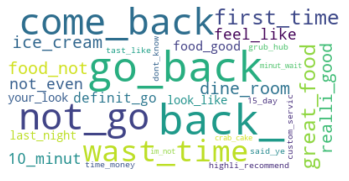

0    False
1    False
2    False
3    False
4    False
Name: Topic, dtype: bool
    Topic          Words_with_weights  Weight                 Word
60      2            0.002*"go_back"    0.002           "go_back" 
61      2              0.001*"back_"    0.001             "back_" 
62      2          0.001*"come_back"    0.001         "come_back" 
63      2             0.001*"not_go"    0.001            "not_go" 
64      2          0.001*"wast_time"    0.001         "wast_time" 
65      2         0.000*"first_time"    0.000        "first_time" 
66      2         0.000*"great_food"    0.000        "great_food" 
67      2          0.000*"dine_room"    0.000         "dine_room" 
68      2           0.000*"food_not"    0.000          "food_not" 
69      2        0.000*"realli_good"    0.000       "realli_good" 
70      2          0.000*"ice_cream"    0.000         "ice_cream" 
71      2          0.000*"feel_like"    0.000         "feel_like" 
72      2           0.000*"not_even"    0.000    

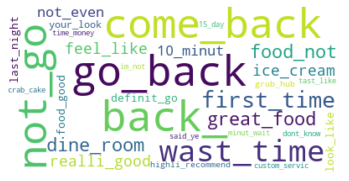

0    False
1    False
2    False
3    False
4    False
Name: Topic, dtype: bool
    Topic          Words_with_weights  Weight                 Word
60      2            0.002*"go_back"    0.002           "go_back" 
61      2              0.001*"back_"    0.001             "back_" 
62      2          0.001*"come_back"    0.001         "come_back" 
63      2             0.001*"not_go"    0.001            "not_go" 
64      2          0.001*"wast_time"    0.001         "wast_time" 
65      2         0.000*"first_time"    0.000        "first_time" 
66      2         0.000*"great_food"    0.000        "great_food" 
67      2          0.000*"dine_room"    0.000         "dine_room" 
68      2           0.000*"food_not"    0.000          "food_not" 
69      2        0.000*"realli_good"    0.000       "realli_good" 
70      2          0.000*"ice_cream"    0.000         "ice_cream" 
71      2          0.000*"feel_like"    0.000         "feel_like" 
72      2           0.000*"not_even"    0.000    

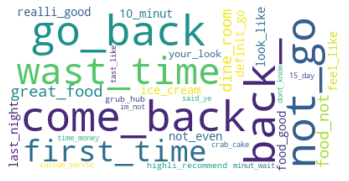

0    False
1    False
2    False
3    False
4    False
Name: Topic, dtype: bool
    Topic          Words_with_weights  Weight                 Word
60      2            0.002*"go_back"    0.002           "go_back" 
61      2              0.001*"back_"    0.001             "back_" 
62      2          0.001*"come_back"    0.001         "come_back" 
63      2             0.001*"not_go"    0.001            "not_go" 
64      2          0.001*"wast_time"    0.001         "wast_time" 
65      2         0.000*"first_time"    0.000        "first_time" 
66      2         0.000*"great_food"    0.000        "great_food" 
67      2          0.000*"dine_room"    0.000         "dine_room" 
68      2           0.000*"food_not"    0.000          "food_not" 
69      2        0.000*"realli_good"    0.000       "realli_good" 
70      2          0.000*"ice_cream"    0.000         "ice_cream" 
71      2          0.000*"feel_like"    0.000         "feel_like" 
72      2           0.000*"not_even"    0.000    

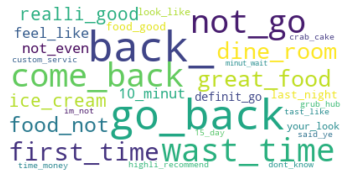

0    False
1    False
2    False
3    False
4    False
Name: Topic, dtype: bool
    Topic          Words_with_weights  Weight                 Word
60      2            0.002*"go_back"    0.002           "go_back" 
61      2              0.001*"back_"    0.001             "back_" 
62      2          0.001*"come_back"    0.001         "come_back" 
63      2             0.001*"not_go"    0.001            "not_go" 
64      2          0.001*"wast_time"    0.001         "wast_time" 
65      2         0.000*"first_time"    0.000        "first_time" 
66      2         0.000*"great_food"    0.000        "great_food" 
67      2          0.000*"dine_room"    0.000         "dine_room" 
68      2           0.000*"food_not"    0.000          "food_not" 
69      2        0.000*"realli_good"    0.000       "realli_good" 
70      2          0.000*"ice_cream"    0.000         "ice_cream" 
71      2          0.000*"feel_like"    0.000         "feel_like" 
72      2           0.000*"not_even"    0.000    

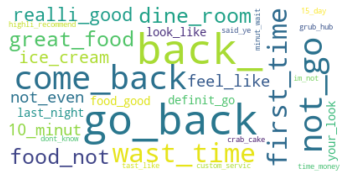

0    False
1    False
2    False
3    False
4    False
Name: Topic, dtype: bool
    Topic          Words_with_weights  Weight                 Word
60      2            0.002*"go_back"    0.002           "go_back" 
61      2              0.001*"back_"    0.001             "back_" 
62      2          0.001*"come_back"    0.001         "come_back" 
63      2             0.001*"not_go"    0.001            "not_go" 
64      2          0.001*"wast_time"    0.001         "wast_time" 
65      2         0.000*"first_time"    0.000        "first_time" 
66      2         0.000*"great_food"    0.000        "great_food" 
67      2          0.000*"dine_room"    0.000         "dine_room" 
68      2           0.000*"food_not"    0.000          "food_not" 
69      2        0.000*"realli_good"    0.000       "realli_good" 
70      2          0.000*"ice_cream"    0.000         "ice_cream" 
71      2          0.000*"feel_like"    0.000         "feel_like" 
72      2           0.000*"not_even"    0.000    

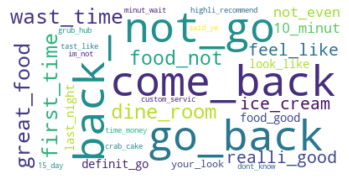

0    False
1    False
2    False
3    False
4    False
Name: Topic, dtype: bool
    Topic          Words_with_weights  Weight                 Word
60      2            0.002*"go_back"    0.002           "go_back" 
61      2              0.001*"back_"    0.001             "back_" 
62      2          0.001*"come_back"    0.001         "come_back" 
63      2             0.001*"not_go"    0.001            "not_go" 
64      2          0.001*"wast_time"    0.001         "wast_time" 
65      2         0.000*"first_time"    0.000        "first_time" 
66      2         0.000*"great_food"    0.000        "great_food" 
67      2          0.000*"dine_room"    0.000         "dine_room" 
68      2           0.000*"food_not"    0.000          "food_not" 
69      2        0.000*"realli_good"    0.000       "realli_good" 
70      2          0.000*"ice_cream"    0.000         "ice_cream" 
71      2          0.000*"feel_like"    0.000         "feel_like" 
72      2           0.000*"not_even"    0.000    

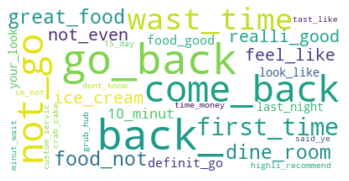

0    False
1    False
2    False
3    False
4    False
Name: Topic, dtype: bool
    Topic          Words_with_weights  Weight                 Word
60      2            0.002*"go_back"    0.002           "go_back" 
61      2              0.001*"back_"    0.001             "back_" 
62      2          0.001*"come_back"    0.001         "come_back" 
63      2             0.001*"not_go"    0.001            "not_go" 
64      2          0.001*"wast_time"    0.001         "wast_time" 
65      2         0.000*"first_time"    0.000        "first_time" 
66      2         0.000*"great_food"    0.000        "great_food" 
67      2          0.000*"dine_room"    0.000         "dine_room" 
68      2           0.000*"food_not"    0.000          "food_not" 
69      2        0.000*"realli_good"    0.000       "realli_good" 
70      2          0.000*"ice_cream"    0.000         "ice_cream" 
71      2          0.000*"feel_like"    0.000         "feel_like" 
72      2           0.000*"not_even"    0.000    

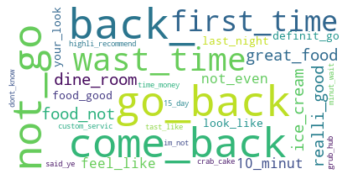

0    False
1    False
2    False
3    False
4    False
Name: Topic, dtype: bool
    Topic          Words_with_weights  Weight                 Word
60      2            0.002*"go_back"    0.002           "go_back" 
61      2              0.001*"back_"    0.001             "back_" 
62      2          0.001*"come_back"    0.001         "come_back" 
63      2             0.001*"not_go"    0.001            "not_go" 
64      2          0.001*"wast_time"    0.001         "wast_time" 
65      2         0.000*"first_time"    0.000        "first_time" 
66      2         0.000*"great_food"    0.000        "great_food" 
67      2          0.000*"dine_room"    0.000         "dine_room" 
68      2           0.000*"food_not"    0.000          "food_not" 
69      2        0.000*"realli_good"    0.000       "realli_good" 
70      2          0.000*"ice_cream"    0.000         "ice_cream" 
71      2          0.000*"feel_like"    0.000         "feel_like" 
72      2           0.000*"not_even"    0.000    

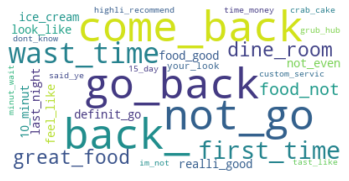

0    False
1    False
2    False
3    False
4    False
Name: Topic, dtype: bool
    Topic          Words_with_weights  Weight                 Word
60      2            0.002*"go_back"    0.002           "go_back" 
61      2              0.001*"back_"    0.001             "back_" 
62      2          0.001*"come_back"    0.001         "come_back" 
63      2             0.001*"not_go"    0.001            "not_go" 
64      2          0.001*"wast_time"    0.001         "wast_time" 
65      2         0.000*"first_time"    0.000        "first_time" 
66      2         0.000*"great_food"    0.000        "great_food" 
67      2          0.000*"dine_room"    0.000         "dine_room" 
68      2           0.000*"food_not"    0.000          "food_not" 
69      2        0.000*"realli_good"    0.000       "realli_good" 
70      2          0.000*"ice_cream"    0.000         "ice_cream" 
71      2          0.000*"feel_like"    0.000         "feel_like" 
72      2           0.000*"not_even"    0.000    

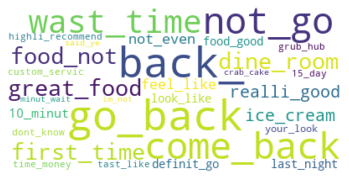

0    False
1    False
2    False
3    False
4    False
Name: Topic, dtype: bool
    Topic          Words_with_weights  Weight                 Word
60      2            0.002*"go_back"    0.002           "go_back" 
61      2              0.001*"back_"    0.001             "back_" 
62      2          0.001*"come_back"    0.001         "come_back" 
63      2             0.001*"not_go"    0.001            "not_go" 
64      2          0.001*"wast_time"    0.001         "wast_time" 
65      2         0.000*"first_time"    0.000        "first_time" 
66      2         0.000*"great_food"    0.000        "great_food" 
67      2          0.000*"dine_room"    0.000         "dine_room" 
68      2           0.000*"food_not"    0.000          "food_not" 
69      2        0.000*"realli_good"    0.000       "realli_good" 
70      2          0.000*"ice_cream"    0.000         "ice_cream" 
71      2          0.000*"feel_like"    0.000         "feel_like" 
72      2           0.000*"not_even"    0.000    

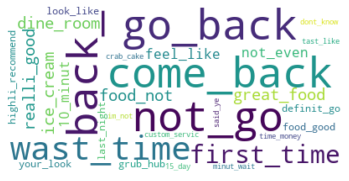

0    False
1    False
2    False
3    False
4    False
Name: Topic, dtype: bool
    Topic          Words_with_weights  Weight                 Word
60      2            0.002*"go_back"    0.002           "go_back" 
61      2              0.001*"back_"    0.001             "back_" 
62      2          0.001*"come_back"    0.001         "come_back" 
63      2             0.001*"not_go"    0.001            "not_go" 
64      2          0.001*"wast_time"    0.001         "wast_time" 
65      2         0.000*"first_time"    0.000        "first_time" 
66      2         0.000*"great_food"    0.000        "great_food" 
67      2          0.000*"dine_room"    0.000         "dine_room" 
68      2           0.000*"food_not"    0.000          "food_not" 
69      2        0.000*"realli_good"    0.000       "realli_good" 
70      2          0.000*"ice_cream"    0.000         "ice_cream" 
71      2          0.000*"feel_like"    0.000         "feel_like" 
72      2           0.000*"not_even"    0.000    

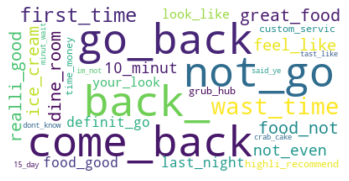

0    False
1    False
2    False
3    False
4    False
Name: Topic, dtype: bool
    Topic          Words_with_weights  Weight                 Word
60      2            0.002*"go_back"    0.002           "go_back" 
61      2              0.001*"back_"    0.001             "back_" 
62      2          0.001*"come_back"    0.001         "come_back" 
63      2             0.001*"not_go"    0.001            "not_go" 
64      2          0.001*"wast_time"    0.001         "wast_time" 
65      2         0.000*"first_time"    0.000        "first_time" 
66      2         0.000*"great_food"    0.000        "great_food" 
67      2          0.000*"dine_room"    0.000         "dine_room" 
68      2           0.000*"food_not"    0.000          "food_not" 
69      2        0.000*"realli_good"    0.000       "realli_good" 
70      2          0.000*"ice_cream"    0.000         "ice_cream" 
71      2          0.000*"feel_like"    0.000         "feel_like" 
72      2           0.000*"not_even"    0.000    

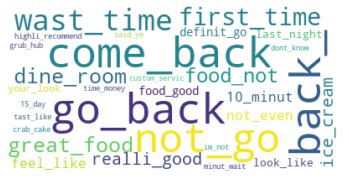

0    False
1    False
2    False
3    False
4    False
Name: Topic, dtype: bool
    Topic          Words_with_weights  Weight                 Word
60      2            0.002*"go_back"    0.002           "go_back" 
61      2              0.001*"back_"    0.001             "back_" 
62      2          0.001*"come_back"    0.001         "come_back" 
63      2             0.001*"not_go"    0.001            "not_go" 
64      2          0.001*"wast_time"    0.001         "wast_time" 
65      2         0.000*"first_time"    0.000        "first_time" 
66      2         0.000*"great_food"    0.000        "great_food" 
67      2          0.000*"dine_room"    0.000         "dine_room" 
68      2           0.000*"food_not"    0.000          "food_not" 
69      2        0.000*"realli_good"    0.000       "realli_good" 
70      2          0.000*"ice_cream"    0.000         "ice_cream" 
71      2          0.000*"feel_like"    0.000         "feel_like" 
72      2           0.000*"not_even"    0.000    

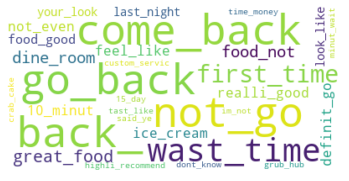

In [41]:
#Visualizing over each topic
for i in range(20):
    is_topic_2 =  new_df['Topic']==2
    print(is_topic_2.head())
    new_df_topic_2 = new_df[is_topic_2]
    print(new_df_topic_2)
    # Start with one review:
    text = " ".join(review for review in new_df_topic_2.Word)

    # lower max_font_size, change the maximum number of word and lighten the background:
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()  
    

In [42]:
#Individual word clouds
#Visualizing over each topic
# is_topic_0 =  new_df['Topic']==0
# print(is_topic_0.head())
# new_df_topic_0 = new_df[is_topic_0]
# new_df_topic_0

# # Start with one review:
# text = " ".join(review for review in new_df_topic_0.Word)

# # lower max_font_size, change the maximum number of word and lighten the background:
# wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
# plt.figure()
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.show()

# #Visualizing over each topic
# is_topic_1 =  new_df['Topic']==1
# print(is_topic_1.head())
# new_df_topic_1 = new_df[is_topic_1]
# print(new_df_topic_1)
# # Start with one review:
# text = " ".join(review for review in new_df_topic_1.Word)

# # lower max_font_size, change the maximum number of word and lighten the background:
# wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
# plt.figure()
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.show

# #Visualizing over each topic
# is_topic_2 =  new_df['Topic']==2
# print(is_topic_2.head())
# new_df_topic_2 = new_df[is_topic_2]
# print(new_df_topic_2)
# # Start with one review:
# text = " ".join(review for review in new_df_topic_2.Word)

# # lower max_font_size, change the maximum number of word and lighten the background:
# wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
# plt.figure()
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.show()

# #Visualizing over each topic
# is_topic_3 =  new_df['Topic']==3
# print(is_topic_3.head())
# new_df_topic_3 = new_df[is_topic_3]
# print(new_df_topic_3)
# # Start with one review:
# text = " ".join(review for review in new_df_topic_3.Word)

# # lower max_font_size, change the maximum number of word and lighten the background:
# wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
# plt.figure()
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.show()

# #Visualizing over each topic
# is_topic_4 =  new_df['Topic']==4
# print(is_topic_4.head())
# new_df_topic_4 = new_df[is_topic_4]
# print(new_df_topic_4)
# # Start with one review:
# text = " ".join(review for review in new_df_topic_4.Word)

# # lower max_font_size, change the maximum number of word and lighten the background:
# wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
# plt.figure()
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.show()

# #Visualizing over each topic
# is_topic_5 =  new_df['Topic']==5
# print(is_topic_5.head())
# new_df_topic_5 = new_df[is_topic_5]
# print(new_df_topic_5)
# # Start with one review:
# text = " ".join(review for review in new_df_topic_5.Word)

# # lower max_font_size, change the maximum number of word and lighten the background:
# wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
# plt.figure()
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.show()

# #Visualizing over each topic
# is_topic_6 =  new_df['Topic']==6
# print(is_topic_6.head())
# new_df_topic_6 = new_df[is_topic_6]
# print(new_df_topic_6)
# # Start with one review:
# text = " ".join(review for review in new_df_topic_6.Word)

# # lower max_font_size, change the maximum number of word and lighten the background:
# wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
# plt.figure()
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.show()

# #Visualizing over each topic
# is_topic_7 =  new_df['Topic']==7
# print(is_topic_7.head())
# new_df_topic_7 = new_df[is_topic_7]
# print(new_df_topic_7)
# # Start with one review:
# text = " ".join(review for review in new_df_topic_7.Word)

# # lower max_font_size, change the maximum number of word and lighten the background:
# wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
# plt.figure()
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.show()

# #Visualizing over each topic
# is_topic_8 =  new_df['Topic']==8
# print(is_topic_8.head())
# new_df_topic_8 = new_df[is_topic_8]
# print(new_df_topic_8)
# # Start with one review:
# text = " ".join(review for review in new_df_topic_8.Word)

# # lower max_font_size, change the maximum number of word and lighten the background:
# wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
# plt.figure()
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.show()

# #Visualizing over each topic
# is_topic_9 =  new_df['Topic']==9
# print(is_topic_9.head())
# new_df_topic_9 = new_df[is_topic_9]
# print(new_df_topic_9)
# # Start with one review:
# text = " ".join(review for review in new_df_topic_9.Word)

# # lower max_font_size, change the maximum number of word and lighten the background:
# wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
# plt.figure()
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.show()

# #Visualizing over each topic
# is_topic_10 =  new_df['Topic']==10
# print(is_topic_10.head())
# new_df_topic_10 = new_df[is_topic_10]
# print(new_df_topic_10)
# # Start with one review:
# text = " ".join(review for review in new_df_topic_10.Word)

# # lower max_font_size, change the maximum number of word and lighten the background:
# wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
# plt.figure()
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.show()

# #Visualizing over each topic
# is_topic_11 =  new_df['Topic']==11
# print(is_topic_11.head())
# new_df_topic_11 = new_df[is_topic_11]
# print(new_df_topic_11)
# # Start with one review:
# text = " ".join(review for review in new_df_topic_11.Word)

# # lower max_font_size, change the maximum number of word and lighten the background:
# wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
# plt.figure()
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.show()

# #Visualizing over each topic
# is_topic_12 =  new_df['Topic']==12
# print(is_topic_12.head())
# new_df_topic_12 = new_df[is_topic_12]
# print(new_df_topic_12)
# # Start with one review:
# text = " ".join(review for review in new_df_topic_12.Word)

# # lower max_font_size, change the maximum number of word and lighten the background:
# wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
# plt.figure()
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.show()

# #Visualizing over each topic
# is_topic_13 =  new_df['Topic']==13
# print(is_topic_13.head())
# new_df_topic_13 = new_df[is_topic_13]
# print(new_df_topic_13)
# # Start with one review:
# text = " ".join(review for review in new_df_topic_13.Word)

# # lower max_font_size, change the maximum number of word and lighten the background:
# wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
# plt.figure()
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.show()

# #Visualizing over each topic
# is_topic_14 =  new_df['Topic']==14
# print(is_topic_14.head())
# new_df_topic_14 = new_df[is_topic_14]
# print(new_df_topic_14)
# # Start with one review:
# text = " ".join(review for review in new_df_topic_14.Word)

# # lower max_font_size, change the maximum number of word and lighten the background:
# wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
# plt.figure()
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.show()

# #Visualizing over each topic
# is_topic_15 =  new_df['Topic']==15
# print(is_topic_15.head())
# new_df_topic_15 = new_df[is_topic_15]
# print(new_df_topic_15)
# # Start with one review:
# text = " ".join(review for review in new_df_topic_15.Word)

# # lower max_font_size, change the maximum number of word and lighten the background:
# wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
# plt.figure()
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.show()

# #Visualizing over each topic
# is_topic_16 =  new_df['Topic']==16
# print(is_topic_16.head())
# new_df_topic_16 = new_df[is_topic_16]
# print(new_df_topic_16)
# # Start with one review:
# text = " ".join(review for review in new_df_topic_16.Word)

# # lower max_font_size, change the maximum number of word and lighten the background:
# wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
# plt.figure()
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.show()

# #Visualizing over each topic
# is_topic_17 =  new_df['Topic']==17
# print(is_topic_1.head())
# new_df_topic_17 = new_df[is_topic_17]
# print(new_df_topic_17)
# # Start with one review:
# text = " ".join(review for review in new_df_topic_17.Word)

# # lower max_font_size, change the maximum number of word and lighten the background:
# wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
# plt.figure()
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.show()

# #Visualizing over each topic
# is_topic_18=  new_df['Topic']==18
# print(is_topic_18.head())
# new_df_topic_18 = new_df[is_topic_18]
# print(new_df_topic_18)
# # Start with one review:
# text = " ".join(review for review in new_df_topic_1.Word)

# # lower max_font_size, change the maximum number of word and lighten the background:
# wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
# plt.figure()
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.show()

# #Visualizing over each topic
# is_topic_19 =  new_df['Topic']==19
# print(is_topic_19.head())
# new_df_topic_19 = new_df[is_topic_19]
# print(new_df_topic_19)
# # Start with one review:
# text = " ".join(review for review in new_df_topic_19.Word)

# # lower max_font_size, change the maximum number of word and lighten the background:
# wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
# plt.figure()
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.show()

# MODELLING

## Peperation of Bag of Words Feature Matrix

In [43]:
df = load_data("BalRev.csv")

In [44]:
vocab = generate_vocab(df, 1, 0,0)
# vocab = pd.read_csv('Vocab.csv')

Vocabulary Generated Successfully.
Vocabulary of  4648  words created


In [45]:
df_processed = proc_df(df)
bag_of_words = populate_bag(df_processed, vocab)
bag_of_words = bag_of_words.sample(frac =1)
# bag_of_words = pd.read_csv('Jupyter/BagOWords.csv')
# bag_of_words = bag_of_words.iloc[:,1:len(bag_of_words.columns)]

Bag of Words Populated Successfully.


## Preparation of Topic Modeling Feature Matrix

In [46]:
df_train = df

In [47]:
df_sampled= resample_df(df_train)
df_proc = proc_df(df_sampled)

In [48]:
df_bigram = bag_of_bigram(df_proc)
df_bigram

stars                                               text  \
0         2  Drinks were great as was the bartender.  Then ...   
1         1  I would give this zero stars if that was an op...   
2         1  Filthy n terrible customer service. I stood th...   
3         1  Rating: 0.5/5 \r\n\r\nI had high hopes for thi...   
4         2  Waited over 30 minutes for my free birthday pi...   
...     ...                                                ...   
1995      5  What a place! This is truly a modern dentist o...   
1996      5  I love this place. It's a haven to relax and r...   
1997      5  Fantastic variety and sizes of succulents and ...   
1998      5  If I had the prowess to open my own restaurant...   
1999      4  The Painted Pin is a neat hangout place in Buc...   

                                              processed  sentiment  \
0     drink great bartend bar food return calamari b...       -1.0   
1     would give zero star option aw custom servic o...       -1.0   
2     filthi n terribl custom servic stood almost 10...       -1.0   
3     rate 055 high hope place especi see zagat rate...       -1.0   
4     wait 30 minut free birthday pizza juli 29th 20...       -1.0   
...                                                 ...        ...   
1995  place truli modern dentist offic saw dr sassi ...        1.0   
1996  love place relax restor feel welcom everi time...        1.0   
1997  fantast varieti size succul cacti plu pot galo...        1.0   
1998  prowess open restaur im pretti sure itd look h...        1.0   
1999  paint pin neat hangout place buckhead array en...        1.0   

                                                 bigram  
0     [drink_great, great_bartend, bartend_bar, bar_...  
1     [would_give, give_zero, zero_star, star_option...  
2     [filthi_n, n_terribl, terribl_custom, custom_s...  
3     [rate_055, 055_high, high_hope, hope_place, pl...  
4     [wait_30, 30_minut, minut_free, free_birthday,...  
...                                                 ...  
1995  [place_truli, truli_modern, modern_dentist, de...  
1996  [love_place, place_relax, relax_restor, restor...  
1997  [fantast_varieti, varieti_size, size_succul, s...  
1998  [prowess_open, open_restaur, restaur_im, im_pr...  
1999  [paint_pin, pin_neat, neat_hangout, hangout_pl...  

[2000 rows x 5 columns]

In [49]:
document_topics=generate_topic(df_bigram)

(0, '0.001*"custom_servic" + 0.001*"go_back" + 0.001*"30_minut" + 0.000*"food_good" + 0.000*"minut_wait" + 0.000*"look_like" + 0.000*"highli_recommend" + 0.000*"never_go" + 0.000*"feel_like" + 0.000*"pretti_good" + 0.000*"seem_like" + 0.000*"servic_great" + 0.000*"servic_would" + 0.000*"place_" + 0.000*"not_even" + 0.000*"chines_food" + 0.000*"not_sure" + 0.000*"4_star" + 0.000*"im_not" + 0.000*"last_time" + 0.000*"price_" + 0.000*"50_minut" + 0.000*"comedi_club" + 0.000*"beer_list" + 0.000*"told_us" + 0.000*"not_abl" + 0.000*"good_food" + 0.000*"minut_get" + 0.000*"ive_ever" + 0.000*"good_servic"')
(1, '0.001*"custom_servic" + 0.001*"come_back" + 0.001*"good_food" + 0.000*"go_back" + 0.000*"5_star" + 0.000*"im_not" + 0.000*"realli_good" + 0.000*"great_place" + 0.000*"back_" + 0.000*"first_time" + 0.000*"would_not" + 0.000*"crab_cake" + 0.000*"happi_hour" + 0.000*"highli_recommend" + 0.000*"ice_cream" + 0.000*"not_go" + 0.000*"long_time" + 0.000*"make_sure" + 0.000*"not_good" + 0.000*"

In [50]:
topic_df = generate_topic_df(document_topics)

In [51]:
topic_df = combine_topics_sentiment(topic_df,df_sampled)
topic_df = topic_df.sample(frac=1)

In [52]:
running_regression(topic_df)

                            OLS Regression Results                            
Dep. Variable:                  stars   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.8961
Date:                Sat, 09 Oct 2021   Prob (F-statistic):              0.588
Time:                        22:35:31   Log-Likelihood:                -3858.1
No. Observations:                2000   AIC:                             7756.
Df Residuals:                    1980   BIC:                             7868.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8724      0.177     16.240      0.0

# TRAINING AND EVALUATION OF MODELS

Splitting the data into inputs and targets

In [53]:
y_bow = bag_of_words['Sentiment']
x_bow = bag_of_words.drop('Sentiment', axis = 1)
# bag_of_words_not_considered = {}

In [54]:
x_topic = topic_df.drop(columns=["stars","sentiment"])
y_topic = topic_df["sentiment"]
y_topic = y_topic.apply(lambda x: 1 if x==1 else 0)

Initializing Model Objects

In [55]:
LR = LogisticRegression()
RF = RandomForestClassifier()
GB = GradientBoostingClassifier()
SV = SVC()

Based on the AUC using the topic models as features, we see that the AUC is poorer than using the bag of words approach. As such, this was deemed unsuitable

## Cross Validation - 10 Fold using AUC as the performance Metric

In [56]:
scoring = {'AUC' : make_scorer(roc_auc_score)}
cv=KFold(n_splits=10)
results_df = pd.DataFrame(columns = ['Model_Name', 'AUC'])
results_df.loc[0,'Model_Name'] = 'BagOfWords_Logistic'
results_df.loc[0,'AUC'] = statistics.mean(cross_val_score(LR, x_bow, y_bow, cv=cv, scoring = 'roc_auc'))
print('1/8 complete')
results_df.loc[1,'Model_Name'] = 'BagOfWords_RandomForest'
results_df.loc[1,'AUC'] = statistics.mean(cross_val_score(RF, x_bow, y_bow, cv=cv, scoring = 'roc_auc'))
clear_output(wait=True)
print('2/8 complete')
results_df.loc[2,'Model_Name'] = 'BagOfWords_GradientBoosting'
results_df.loc[2,'AUC'] = statistics.mean(cross_val_score(GB, x_bow, y_bow, cv=cv, scoring = 'roc_auc'))
clear_output(wait=True)
print('3/8 complete')
results_df.loc[3,'Model_Name'] = 'BagOfWords_SupportVector'
results_df.loc[3,'AUC'] = statistics.mean(cross_val_score(SV, x_bow, y_bow, cv=cv, scoring = 'roc_auc'))
clear_output(wait=True)
print('4/8 complete')
results_df.loc[4,'Model_Name'] = 'Topic_Logistic'
results_df.loc[4,'AUC'] = statistics.mean(cross_val_score(LR, x_topic, y_topic, cv=cv, scoring = 'roc_auc'))
clear_output(wait=True)
print('5/8 complete')
results_df.loc[5,'Model_Name'] = 'Topic_RandomForest'
results_df.loc[5,'AUC'] = statistics.mean(cross_val_score(RF, x_topic, y_topic, cv=cv, scoring = 'roc_auc'))
clear_output(wait=True)
print('6/8 complete')
results_df.loc[6,'Model_Name'] = 'Topic_GradientBoosting'
results_df.loc[6,'AUC'] = statistics.mean(cross_val_score(GB, x_topic, y_topic, cv=cv, scoring = 'roc_auc'))
clear_output(wait=True)
print('7/8 complete')
results_df.loc[7,'Model_Name'] = 'Topic_SupportVector'
results_df.loc[7,'AUC'] = statistics.mean(cross_val_score(SV, x_topic, y_topic, cv=cv, scoring = "roc_auc"))
clear_output(wait=True)
print('8/8 complete')
# plt.bar(results_df.Model_Name,results_df.AUC)
# print('Mean BOW_Logistic AUC: ', statistics.mean(cross_validate(LR, x_bow, y_bow, cv=10, scoring = scoring)['test_AUC']))
# print('Mean BOW_Random Forest AUC: ', statistics.mean(cross_validate(RF, x_bow, y_bow, cv=10, scoring = scoring)['test_AUC']))
# print('Mean BOW_Gradient Boosting AUC: ', statistics.mean(cross_validate(GB, x_bow, y_bow, cv=10, scoring = scoring)['test_AUC']))
# print('Mean BOW_Support Vector AUC: ', statistics.mean(cross_validate(SV, x_bow, y_bow, cv=10, scoring = scoring)['test_AUC']))
# print('Logistic Accuracy: ', statistics.mean(cross_validate(LR, x, y, cv=10, scoring = scoring)['test_accuracy']))
# print('Random Forest Accuracy: ', statistics.mean(cross_validate(RF, x, y, cv=10, scoring = scoring)['test_accuracy']))
# print('Gradient Boosting Accuracy: ', statistics.mean(cross_validate(GB, x, y, cv=10, scoring = scoring)['test_accuracy']))
# print('Support Vector Accuracy: ', statistics.mean(cross_validate(SV, x, y, cv=10, scoring = scoring)['test_accuracy']))

8/8 complete


## PLOT OF RESULTS

In [66]:
results_df

Model_Name       AUC
0          BagOfWords_Logistic  0.954546
1      BagOfWords_RandomForest   0.94619
2  BagOfWords_GradientBoosting   0.93432
3     BagOfWords_SupportVector  0.943995
4               Topic_Logistic  0.492497
5           Topic_RandomForest  0.542851
6       Topic_GradientBoosting  0.564696
7          Topic_SupportVector  0.493639

Text(0.5, 1.0, 'Mean AUCs for Different Models')

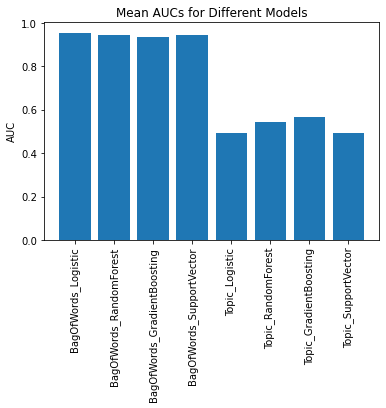

In [57]:
plt.bar(results_df.Model_Name, results_df.AUC)
plt.xticks(rotation= "vertical")
plt.ylabel('AUC')
plt.title('Mean AUCs for Different Models')

## PICKING FINAL MODEL

In [58]:
Final_Model = LogisticRegression(max_iter=100).fit(x_bow,y_bow)
# Final_Model = RandomForestClassifier().fit(x_bow,y_bow)
# Final_Model = GradientBoostingClassifier().fit(x_bow,y_bow)
# Final_Model = SVC().fit(x_bow,y_bow)

# VIRTUAL DEPLOYMENT TO ARRIVE AT THRESHOLD PARAMETER
Taking a sample of 1000 reviews from unused data and testing them using the trained model to determine what the best threshold is

In [59]:
df_test = load_data('yelp_data_cleaned.csv')
df_test= df_test[8000:9000]
df_test = df_test.reset_index(drop=1)
df_test_processed = proc_df(df_test)
bag_test = populate_bag(df_test_processed,vocab)
test_frame = test_log_frame(bag_test,Final_Model)
acc_test = accuracy_plot(test_frame)
max_test_thres = int(acc_test.loc[acc_test.index[acc_test.Accuracy==max(acc_test.Accuracy)][0],'Perc_thres'])/100
# print(max_test_thres, max(acc_test.Accuracy))

Bag of Words Populated Successfully.


## Plotting the Accuracy and ROC curves

Text(0.5, 1.0, 'Accuracy')

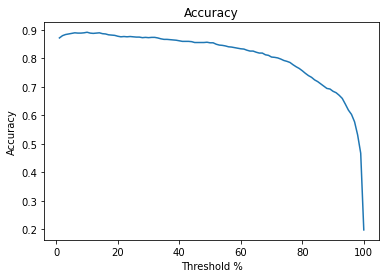

In [60]:
plot1 = plt.plot( acc_test.Perc_thres,acc_test.Accuracy)
plt.xlabel("Threshold %")
plt.ylabel("Accuracy")
plt.title("Accuracy")

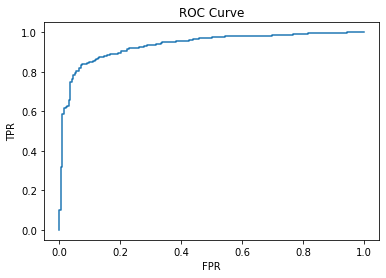

In [61]:
fpr, tpr, thr = roc_curve(test_frame.act, test_frame.prob)

plt.plot(fpr,tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.show()

In [62]:
# Y = bag_test['Sentiment']
# X = bag_test.drop('Sentiment', axis = 1)
# y_pred_LR = LR.predict(X)
# y_pred_RF = RF.predict(X)
# y_pred_GB = GB.predict(X)
# y_pred_SV = SV.predict(X)
# print('Logistic Regression: ')
# print(classification_report(Y, y_pred_LR))
# print(confusion_matrix(Y, y_pred_LR))
# print('Random Forest: ')
# print(classification_report(Y, y_pred_RF))
# print(confusion_matrix(Y, y_pred_RF))
# print('Gradient Boosting: ')
# print(classification_report(Y, y_pred_GB))
# print(confusion_matrix(Y, y_pred_RF))
# print('Support Vector: ')
# print(classification_report(Y, y_pred_SV))
# print(confusion_matrix(Y, y_pred_RF))

In [63]:
pred_frame = test_log_frame(bag_test,Final_Model)

In [64]:
# acc_test = accuracy_plot(pred_frame)
# max_test_thres = int(acc_test.loc[acc_test.index[acc_test.Accuracy==max(acc_test.Accuracy)][0],'Perc_thres'])/100
# print(max_test_thres, max(acc_test.Accuracy))

## Evaluating Cost-Benefit to select Threshold

The optimum threshold is:  0.31
Maximum Expected Gains:  2344.0
Test stats are as follows: 
Contingency Table: 
           Pred. Neg  Pred. Pos
Act. Neg      172.0       26.0
Act. Pos      101.0      701.0
TPR is equal to :  0.8740648379052369
FPR is equal to :  0.13131313131313133
Accuracy for test set is  87.3 % at threshold =  0.31
None


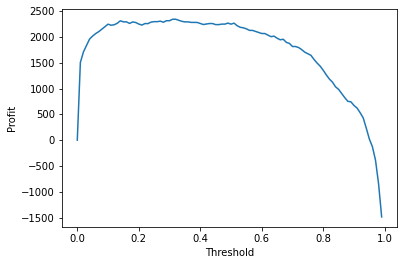

In [65]:
c = pd.DataFrame()
for i in range(100):
    c.loc[i,"thres"] = i/100
    c.loc[i,'EP'] = cost_benefit(test_frame,19.5,0,-10,0,i/100)
    
plt.plot(c.thres,c.EP)
plt.xlabel('Threshold')
plt.ylabel('Profit')
optimum = float(c.loc[c.index[c.EP==max(c.EP)][0],'thres'])
print('The optimum threshold is: ',optimum)
test_frame['pred'] = test_frame['prob']>optimum
print('Maximum Expected Gains: ', cost_benefit(test_frame,19.5,0,-10,0,optimum))
print(test_statistics(test_frame,optimum))